# Workbook 12 - Time Series
by [Dr. David Elliott](https://eldave93.netlify.app/)

1. [Workspace Setup](#setup)

2. [Data Preparation](#prep)

3. [Exploratory Data Analysis](#eda)

4. [Model Exploration/Refinement](#explore)

The aim of this workbook is to...

# 1. Workspace Setup <a id='setup'></a>
Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.1. Google Colab
If you are using google colab then you can follow the below instructions to get setup.

First lets check if you are actually using google colab.

In [1]:
try:
    import google.colab
    COLAB=True
    
    # set the week code
    WORKSHOP_NAME = "12-time-series"
except:
    COLAB=False

If using colab you will need to install the dependencies and upload the files associated with this workshop to the temporary file store.

To do this:
1. Download the workbook repository as a .zip file from GitHub (Green "Code" button, "Download ZIP"),
2. On Google Colab click the folder icon on the left panel
3. Click the page icon with the upwards arrow on it
4. From your local computers file store, upload the .zip file (e.g. `machine-learning-workbooks-main.zip`)

__Note__ 

- Make sure to restart the runtime after installing to ensure everything works correctly.

In [2]:
if COLAB:
    import os

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists("machine-learning-workbooks-main") and os.path.exists("machine-learning-workbooks-main.zip"):
          !unzip machine-learning-workbooks-main.zip
          
    print("Setting working directory to:")
    %cd ./machine-learning-workbooks-main/{WORKSHOP_NAME}

else:
    print("Colab is not being used")

Colab is not being used


As seen above, I automatically set the working directory to be a local version of the workshop repository. This is so all the data, images, and scripts for displaying the solutions works. This is located on the temporary file store associated with this colabs runtime. 

## 1.2. Local Workspace

If your using a local workspace you will need all the packages to run this notebook.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from datetime import date
import re

sys.path.append('../scripts') # add scripts to the path for use later

If you do not already have them the script below, provided `AUTO_INSTALL = True`, will install them for you.

In [4]:
AUTO_INSTALL = False

if AUTO_INSTALL:
    !{sys.executable} -m pip install -r ../scripts/requirements.txt

## 1.3. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workshop folder (e.g. `01-end_to_end`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).

In [5]:
%run ../scripts/create_widgets.py 12

Solutions .txt file not found!


In [6]:
# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

---

# 2. Data Preparation <a id='prep'></a>

---

### 🚩 Exercise 1

List some examples of real-world time series data.

In [7]:
%run ../scripts/show_solutions.py 12_ex1

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Lets start by loading in some COVID case numbers.

__Note:__
If you turn `UPDATE = True`, it will save the latest covid rate data from the UK government website.

In [8]:
UPDATE = False

if UPDATE == True:
    # get the latest covid-19 UK data 
    covid_eng = pd.read_csv("https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation;areaName=England&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newCasesBySpecimenDate%22:%22newCasesBySpecimenDate%22,%22cumCasesBySpecimenDate%22:%22cumCasesBySpecimenDate%22,%22newFirstEpisodesBySpecimenDate%22:%22newFirstEpisodesBySpecimenDate%22,%22cumFirstEpisodesBySpecimenDate%22:%22cumFirstEpisodesBySpecimenDate%22,%22newReinfectionsBySpecimenDate%22:%22newReinfectionsBySpecimenDate%22,%22cumReinfectionsBySpecimenDate%22:%22cumReinfectionsBySpecimenDate%22%7D&format=csv")
    # save to csv
    covid_eng.to_csv("./Data/covid_rates_"+str(date.today())+".csv", index=False)
    
# get a list of the data files
onlyfiles = [f for f in os.listdir("Data") if os.path.isfile(os.path.join("Data", f))]
# only get the covid data
covidlist = list(filter(re.compile("covid_rates_*").match, onlyfiles))
# load the latest data
covid_eng = pd.read_csv("./Data/"+covidlist[-1])

# display the first few rows
covid_eng.head()

,areaType,areaName,areaCode,date,newCasesBySpecimenDate,cumCasesBySpecimenDate,newFirstEpisodesBySpecimenDate,cumFirstEpisodesBySpecimenDate,newReinfectionsBySpecimenDate,cumReinfectionsBySpecimenDate
0,nation,England,E92000001,2022-09-28,4865,19968866,3634,18700879,1231.0,1267987.0
1,nation,England,E92000001,2022-09-27,6950,19964001,5117,18697245,1833.0,1266756.0
2,nation,England,E92000001,2022-09-26,7623,19957051,5542,18692128,2081.0,1264923.0
3,nation,England,E92000001,2022-09-25,6532,19949428,4802,18686586,1730.0,1262842.0
4,nation,England,E92000001,2022-09-24,5144,19942896,3884,18681784,1260.0,1261112.0


This is just the covid infection data for England, and therfore only has one `areaCode`. For the sake of this workshop we are only going to look at `newCasesBySpecimenDate` which we will rename to `new_cases`.

In [9]:
covid = covid_eng[["date", "newCasesBySpecimenDate"]].copy()
covid.rename(mapper={"newCasesBySpecimenDate": "new_cases"},axis='columns', inplace=True)
covid.head()

,date,new_cases
0,2022-09-28,4865
1,2022-09-27,6950
2,2022-09-26,7623
3,2022-09-25,6532
4,2022-09-24,5144


Notice that at the moment `date` is curently stored as an "object" - meaning it is a string of text.

In [10]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       973 non-null    object
 1   new_cases  973 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ KB


This makes it difficult to work with - how do we extract the year, for instance? How does Python know what order the times go in to plot them? To let Python  know this is a date so need to turn this into a `date` object. To do this we are going to need to use Python's `DateTime` library, so lets take a quick detour away from our data and into looking into this package.

---

## `DateTime`

Python's `DateTime` library is great for dealing with time-related data, and Pandas has incorporated this library into its own `datetime` series and objects. Below, we'll load in the `DateTime` library, which we can use to create a `datetime` object by entering in the different components of the date as arguments.

In [11]:
from datetime import datetime

Let's just start with an example date.

In [12]:
example_date = datetime(2022, 6, 7) # 07-06-2022
example_date

datetime.datetime(2022, 6, 7, 0, 0)

The components of the date are accessible via the object's attributes.

In [13]:
print("Year", example_date.year)
print("Month",example_date.month)
print("Day", example_date.day)
print("Hour", example_date.hour)
print("Minute", example_date.minute)
print("Second", example_date.second)
print("Micro-Second", example_date.microsecond)

Year 2022
Month 6
Day 7
Hour 0
Minute 0
Second 0
Micro-Second 0


Notice that from the hour is set to 0, this is because we didn't specify an hour, but if we needed this information we could.

In [14]:
example_date = datetime(2022, 6, 7, 8, 30) # 07-06-2022 08:30

print("Year", example_date.year)
print("Month",example_date.month)
print("Day", example_date.day)
print("Hour", example_date.hour)
print("Minute", example_date.minute)

Year 2022
Month 6
Day 7
Hour 8
Minute 30


---

### 🚩 Exercise 2

Convert the following strings to datetime format:

- 19 October 2021, 10:13 AM

- 31 May 2022, 09:30 AM

- 25 November 2021, 15:30 PM

In [15]:
%run ../scripts/show_solutions.py 12_ex2

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 3

Using the datetime objects above, print out their elements (e.g. month, hour)

In [16]:
%run ../scripts/show_solutions.py 12_ex3

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### `timedelta()`

If we wanted to add or subtract time from a date we could use a `timedelta` object to shift a `datetime` object. An example of when you may want to do this is when time is your index and you want to get everything that happened a week before a specific observation.

In [17]:
# Import timedelta() from the DateTime library.
from datetime import timedelta

# Timedeltas represent time as an amount rather than as a fixed position.
offset = timedelta(days=1)

# The timedelta() has attributes that allow us to extract values from it.
print('offset days', offset.days)

offset days 1


`datetime`'s `.now()` function will give you the `datetime` object of right now.

In [18]:
now = datetime.now()
print("right now:", now)

right now: 2022-12-19 13:00:47.978650


We can use `timedelta()` on the time now.

In [19]:
print("Past: ", now - offset)
print("Future: ", now + offset)

Past:  2022-12-18 13:00:47.978650
Future:  2022-12-20 13:00:47.978650


Note: The largest value a `timedelta()` can hold is days so if you want to shift by years you will have to convert it to days (see [here](https://docs.python.org/2/library/datetime.html)) or use `pd.DateOffset()`.

---

### 🚩 Exercise 4

Using the datetime objects created in exercise 3, find out the date 30 days before them.

In [20]:
%run ../scripts/show_solutions.py 12_ex4

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Right lets get back to our COVID data! The first step when working with time information is to convert it to a datetime format. The problem is that dates and times can be written in lots of different ways. For example, the following are all valid formats for the same datetime - and there are loads more! 

- 6/1/1930 22:00

- 06/01/1930 22:00

- 01/06/1930 22:00

- 1/6/1930 22:00

- 1930-06-01 22:00:00

- 1st June 1930 22:00

- June 1st 1930 10pm

Pandas ``to_datetime`` function will try to figure out what format it's reading, but it can sometimes take a while and might get it wrong.

In [21]:
%%time
# letting pandas figure out the format for itself - slow and may be wrong
pd.to_datetime(covid.date)

Wall time: 5.71 ms


0     2022-09-28
1     2022-09-27
2     2022-09-26
3     2022-09-25
4     2022-09-24
         ...    
968   2020-02-03
969   2020-02-02
970   2020-02-01
971   2020-01-31
972   2020-01-30
Name: date, Length: 973, dtype: datetime64[ns]

You should generally try to figure out the format yourself and tell the function using a format code.

The codes used below are:

code | represents
--|--
%Y| year
%m | month
%d | day

In [22]:
%%time
# telling pandas the format.
# We use the - between %Y and %m as the format of our dates have
# -'s. 
covid.date = pd.to_datetime(covid.date, format='%Y-%m-%d')

covid.date

Wall time: 1e+03 µs


0     2022-09-28
1     2022-09-27
2     2022-09-26
3     2022-09-25
4     2022-09-24
         ...    
968   2020-02-03
969   2020-02-02
970   2020-02-01
971   2020-01-31
972   2020-01-30
Name: date, Length: 973, dtype: datetime64[ns]

---

### 🚩 Exercise 5

Convert the following strings to datetime format using `pd.to_datetime`:

- `"19 October 2021, 10:13 AM"`

- `"Oct 19 2021 - 10h13"`

- `"2021-10-19 10:13:29"`

__Hint__

To open the docs to grab the website for looking at datetime format codes (under the format info)
```
?pd.to_datetime
```

...or google "pandas strftime format codes"

In [23]:
%run ../scripts/show_solutions.py 12_ex5

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

You can see that each of these dates are now `datetime64` so have the properties of the datetime objects we created before.

In [24]:
print("Year", covid.date[0].year)
print("Month",covid.date[0].month)
print("Day", covid.date[0].day)

Year 2022
Month 9
Day 28


If we want a particular part it can be useful to define a function to do this...

In [25]:
def extract_day(datetime):
    return datetime.day

extract_day(covid.date[0])

28

...we can then apply this to the Time column

In [26]:
covid.date.apply(extract_day)

0      28
1      27
2      26
3      25
4      24
       ..
968     3
969     2
970     1
971    31
972    30
Name: date, Length: 973, dtype: int64

---

### 🚩 Exercise 6

Extract the year of each of the datetimes in the covid dataset

In [27]:
%run ../scripts/show_solutions.py 12_ex6

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
We need to use `.apply` if doing something more complicated e.g., classify dates into "this year", "last year", or "other".

In [28]:
def year_classifier(datetime):
    year = datetime.year
    if year < 2021:
        return 'this year'
    elif year < 2020:
        return 'last year'
    else:
        return 'other'
covid.date.apply(year_classifier)

0          other
1          other
2          other
3          other
4          other
         ...    
968    this year
969    this year
970    this year
971    this year
972    this year
Name: date, Length: 973, dtype: object

## Filtering
Pandas lets you filter in the obvious way on datetimes - you can do ```d1 < d2``` where `d1` and `d2` are datetime objects.

In [29]:
now

datetime.datetime(2022, 12, 19, 13, 0, 47, 978650)

In [30]:
earlier = pd.to_datetime('2021-09-01')
earlier

Timestamp('2021-09-01 00:00:00')

In [31]:
now < earlier

False

In [32]:
now > earlier

True

In [33]:
now == earlier

False

To filter on a dataframe, we need a mask. A mask is a column of `True`/`False` values. We make a mask by applying a comparison to a column:

In [34]:
twenty1 = pd.to_datetime('2021', format='%Y')
mask = covid.date < twenty1
mask

0      False
1      False
2      False
3      False
4      False
       ...  
968     True
969     True
970     True
971     True
972     True
Name: date, Length: 973, dtype: bool

In [35]:
# use square brackets to filter the dataframe with the mask
display(covid[mask])

# or can just use 
# covid[covid.date < twenty1]

,date,new_cases
636,2020-12-31,47823
637,2020-12-30,64243
638,2020-12-29,74058
639,2020-12-28,40846
640,2020-12-27,43250
...,...,...
968,2020-02-03,18
969,2020-02-02,1
970,2020-02-01,0
971,2020-01-31,0


---

### 🚩 Exercise 7

Find how many new cases have been reported since June 1st 2021.

In [36]:
%run ../scripts/show_solutions.py 12_ex7

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

After converting the column containing time data from object to `datetime`, for filtering it is also useful to make the index of the DataFrame a `datetime`.

In [37]:
# sort earliest to most recent
covid.sort_values(by='date', inplace=True)
# Set the date to the index 
covid.set_index('date', inplace=True)

# Preview the data 
covid.head()

,new_cases
date,
2020-01-30,1
2020-01-31,0
2020-02-01,0
2020-02-02,1
2020-02-03,18


With the index as a datetime, it is also easy to plot the data with matplotlib.

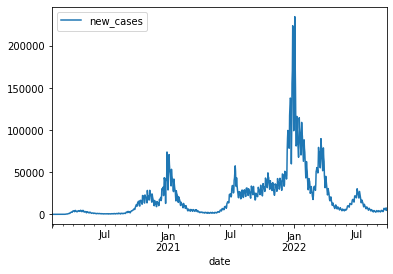

In [38]:
covid.plot()
plt.show()

---

### 🚩 Exercise 8

By filtering your data, plot only the covid cases that happened in 2021.

In [39]:
%run ../scripts/show_solutions.py 12_ex8

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

## Resampling

The Covid data is nice and regular giving us one value per day. However what do we do when the data doesn't look like that?

Lets have a look at another dataset, UFO sightings!

In [40]:
import pandas as pd

ufo = pd.read_csv('./Data/ufo.csv')

ufo.head()

,City,Colors Reported,Shape Reported,State,Time
0,Ithaca,NaN,TRIANGLE,NY,6/1/1930 22:00
1,Willingboro,NaN,OTHER,NJ,6/30/1930 20:00
2,Holyoke,NaN,OVAL,CO,2/15/1931 14:00
3,Abilene,NaN,DISK,KS,6/1/1931 13:00
4,New York Worlds Fair,NaN,LIGHT,NY,4/18/1933 19:00


Lets do some data cleaning to get this data ready to be used as a timeseries.

In [41]:
from helper_functions import clean_ufos

ufo = clean_ufos(ufo)

ufo.head()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-01 22:00:00,Ithaca,NaN,TRIANGLE,NY
1930-06-30 20:00:00,Willingboro,NaN,OTHER,NJ
1931-02-15 14:00:00,Holyoke,NaN,OVAL,CO
1931-06-01 13:00:00,Abilene,NaN,DISK,KS
1933-04-18 19:00:00,New York Worlds Fair,NaN,LIGHT,NY


---

### 🚩 Exercise 9

Write your own function to clean the data as above (change `Time` to a `datetime` and set as an index)

In [42]:
%run ../scripts/show_solutions.py 12_ex9

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Lets stop a second and think about out the UFO dataset. Is it a time series? 

It's a little ambiguous, but normally when we talk about time series data, we mean that recordings are made <em>at regular time intervals</em>. So we have a single (usually numeric) value for each day (or each month, or each second, ...)

So the ufo dataset isn't what we'd normally call a time series, because it has irregular intervals, and can have multiple records at the same time. However, we can convert it to a more regular time series by <em>resampling</em>. To do this, we need the time as the index of the dataframe, which is usual for time series.

To start with, we could resample to get a value for every month. Like `groupby`, `resample` needs an aggregate function to know how to combine multiple values in the same time period. For example we can aggregate into monthly data...

In [43]:
ufo.resample('M').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-30,2,0,2,2
1930-07-31,0,0,0,0
1930-08-31,0,0,0,0
1930-09-30,0,0,0,0
1930-10-31,0,0,0,0
...,...,...,...,...
2014-05-31,593,197,535,593
2014-06-30,709,216,669,710
2014-07-31,1006,386,929,1006


...yearly...

In [44]:
ufo.resample('Y').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-12-31,2,0,2,2
1931-12-31,2,0,2,2
1932-12-31,0,0,0,0
1933-12-31,1,0,1,1
1934-12-31,1,0,1,1
...,...,...,...,...
2010-12-31,4154,849,3769,4154
2011-12-31,5087,1278,4650,5089
2012-12-31,7263,2239,6679,7263


...or daily.

In [45]:
ufo.resample('D').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-01,1,0,1,1
1930-06-02,0,0,0,0
1930-06-03,0,0,0,0
1930-06-04,0,0,0,0
1930-06-05,0,0,0,0
...,...,...,...,...
2014-09-01,25,7,22,25
2014-09-02,15,3,13,15
2014-09-03,24,8,23,24


Resampling can also be used to change the level of granularity. E.g., if you have hourly data and you want to study long term trends over a year, you might resample to daily, weekly, or monthly level with a sum or mean as aggregate

In [46]:
# make this resampling permanent, and also extract only the state column, 
# as that has no nulls in
ufo_state_count = ufo.resample('Y').count()['State']
ufo_state_count

Time
1930-12-31       2
1931-12-31       2
1932-12-31       0
1933-12-31       1
1934-12-31       1
              ... 
2010-12-31    4154
2011-12-31    5089
2012-12-31    7263
2013-12-31    7003
2014-12-31    5382
Freq: A-DEC, Name: State, Length: 85, dtype: int64

If we plot the data we can see that the number of sightings has been increasing, peaking in 2012.

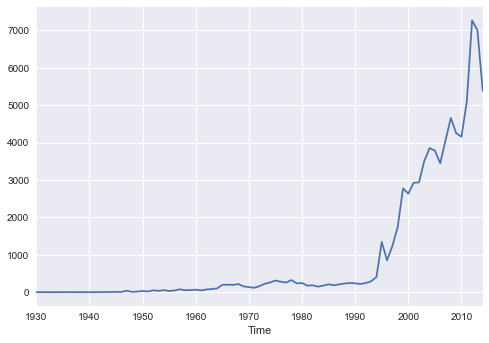

In [47]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

ufo_state_count.plot();

---

### 🚩 Exercise 10

Using the UK daily covid rate data resample to weekly counts level and plot a graph

In [48]:
%run ../scripts/show_solutions.py 12_ex10

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

# 3. Exploratory Data Analysis <a id='eda'></a>

## 3.1. Trends

A trend is any long-term change in the value we're measuring. For example, between the start of December 2020 and the second week of January 2021, there was an upward trend in Covid cases.

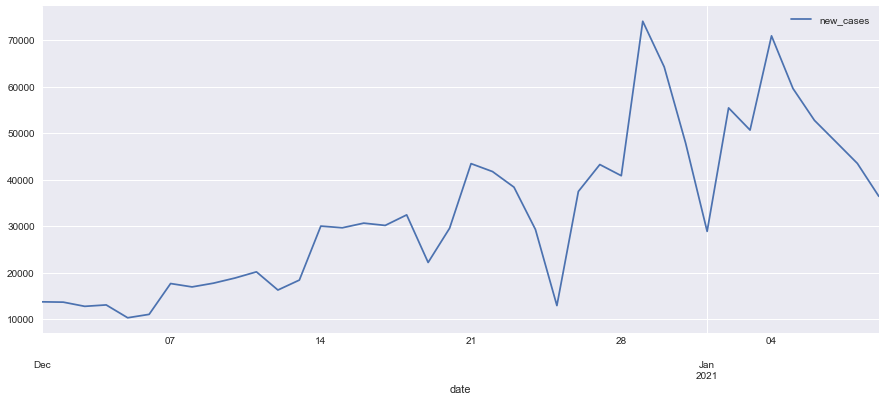

In [49]:
# let's filter our data to look at the middle section more closely
start_date = pd.to_datetime('2020-12-01')
end_date = pd.to_datetime('2021-01-10', format='%Y-%m-%d') # using ISO 8601 format, `format=` is optional

after_start = covid.index >= start_date
before_end = covid.index < end_date
mask = after_start & before_end
covid[mask].plot(figsize=(15,6));

A basic fit for this data would be a straight line (or polynomial degree 1; `order=1`).

<ipython-input-50-106812d4acd9>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates_.dt.date)


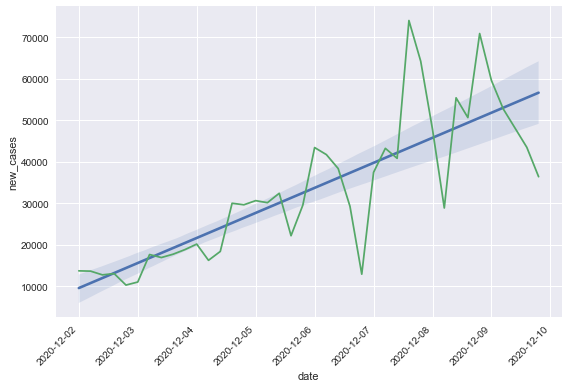

In [50]:
import seaborn as sns

df = covid[mask].copy()

df.reset_index(inplace=True)

# save the dates
dates_ = df.date

# regplot don't play nice with datetimes so lets convert them to
# ordinal values
df["date"] = df.date.map(pd.Timestamp.toordinal)

fig, ax = plt.subplots()

sns.regplot(x='date', y='new_cases', data=df, ax=ax, scatter=False, order=1)
sns.lineplot(x='date', y='new_cases', data=df, ax=ax)

# set our labels back to the dates
ax.set_xticklabels(dates_.dt.date)

# legible labels
fig.autofmt_xdate(rotation=45, ha='right')

fig.tight_layout()

---

### 🚩 Exercise 11

Is above the best fit? 
- Visually change the degree of the polynomial and see if you think there is a better fit. 
- What happens as you keep increasing the degree?

In [51]:
%run ../scripts/show_solutions.py 12_ex11

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
Trends may "change direction" going from an increasing trend to a decreasing trend. Trends can only be measured within the scope of the data collected; there may be trends that are unmeasurable if the data are not complete. For example, if we were to increase the size of the mask from before...

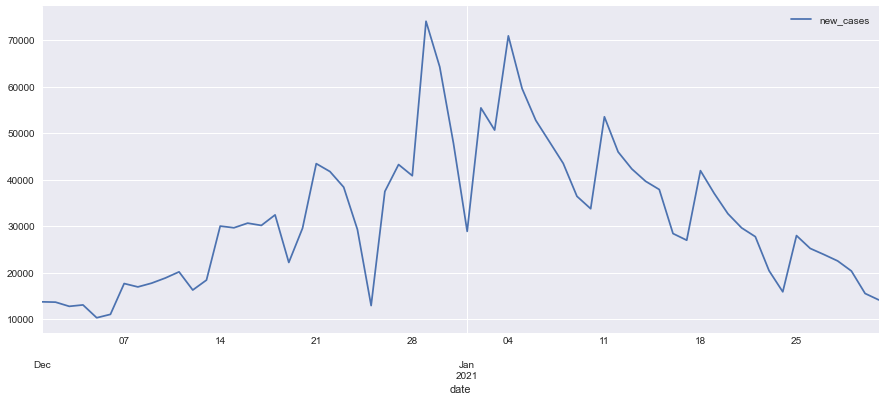

In [52]:
# let's filter our data to look at the middle section more closely
start_date = pd.to_datetime('2020-12-01')
end_date = pd.to_datetime('2021-02-01', format='%Y-%m-%d') # using ISO 8601 format, `format=` is optional

after_start = covid.index >= start_date
before_end = covid.index < end_date
mask = after_start & before_end
covid[mask].plot(figsize=(15,6));

---

### 🚩 Exercise 12

Plot the polynomial regression line on the data above (with the wider mask).

In [53]:
%run ../scripts/show_solutions.py 12_ex12

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Another way we can evaluate trends is by calculating aggregates (mean, median, etc). If we look at the mean/median value of something (i.e. sales, customers) per week/month/year you can start to see trends. Again we can use `.resample()` to calculate aggregates of a given time period. For example if, if you type `"M"` with `.mean()` you will calculate the mean covid cases for every month in the dataset.

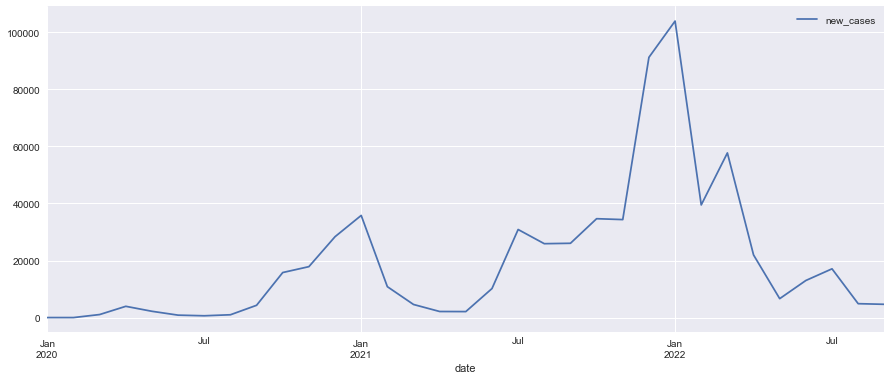

In [54]:
covid_resample = covid.resample("M").mean()
covid_resample.plot(figsize=(15,6));

---
### Rolling Statistics

An advantage of time series is that we can roll statistics over time. For example, a rolling mean is the mean of a moving window across a time period. Pandas has several inbuilt functions that allow us to calculate rolling statistics.

This graph is "spiky" because a lot of tests done on weekends aren't reported until the following Monday or Tuesday, so we get artificially low numbers at weekends, and high numbers at the start of the week. This is an artefact of the way the data are collected, not of the actual variable of interest (covid case numbers).

We can fix this with a 3-day rolling average, which will smooth out these spikes to give a more accurate estimate of the actual number of new cases each day.

In [55]:
covid.rolling(window=3).mean()

,new_cases
date,
2020-01-30,NaN
2020-01-31,NaN
2020-02-01,0.333333
2020-02-02,0.333333
2020-02-03,6.333333
...,...
2022-09-24,5682.000000
2022-09-25,5821.333333
2022-09-26,6433.000000


There are two missing values at the start of this dataframe. This is because at the start there aren't enough data points to average - each data point here is the average of 3 consecutive datapoints in the original time series, so you can only start forming that average by the 3rd data point.

Where the missing values appear in your data will depend on thetype of rolling window you use. You could for example use a centred rolling window...

In [56]:
covid.rolling(window=3, center=True).mean()

,new_cases
date,
2020-01-30,NaN
2020-01-31,0.333333
2020-02-01,0.333333
2020-02-02,6.333333
2020-02-03,6.333333
...,...
2022-09-24,5821.333333
2022-09-25,6433.000000
2022-09-26,7035.000000


Using ```center=True``` means the rolling window is centred on the datapoint of interest. So e.g., Monday's rolling average value will be the average of Sun, Mon, Tue, whereas with a non-centred rolling average it will be the average of Sat, Sun, Mon. Centred rolling averages are better for historical analysis, because each rolling average point is based on the closest possible values, so is more accurate, <strong>but</strong> it means you get nulls in the rolling average at the start <strong>and end</strong> of the time series, (because for today's rolling average you'd need to know tomorrow's data), so if you want to use the rolling average to forecast, you can't use a centred version.

Also, when using ```center=True```, you should use an odd window size, since an even number of dates doesn't have a centre point. For non-centred rolling averages, even or odd window sizes are fine.

If we plot our rolling windowed data out you can see the rolling average is "smoother", but still not totally smooth. 

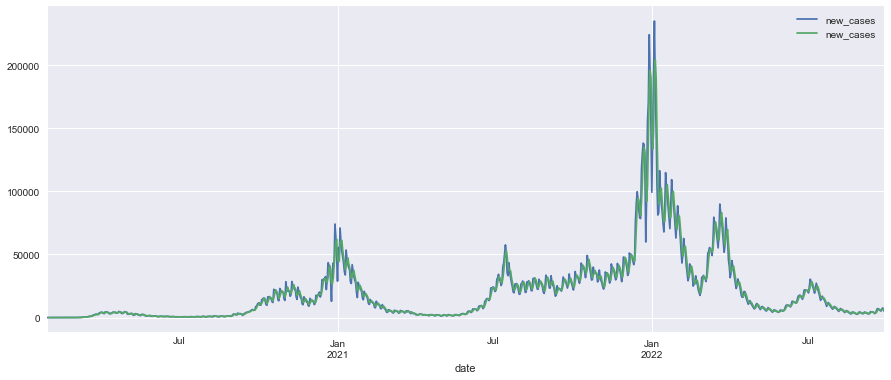

In [57]:
fig, ax = plt.subplots(figsize=(15,6))
covid.plot(ax=ax)
covid.rolling(window=3).mean().plot(ax=ax);

Using a larger window for the rolling average will improve this. 7 is a good window size, since the spikes are caused by a weekly effect.

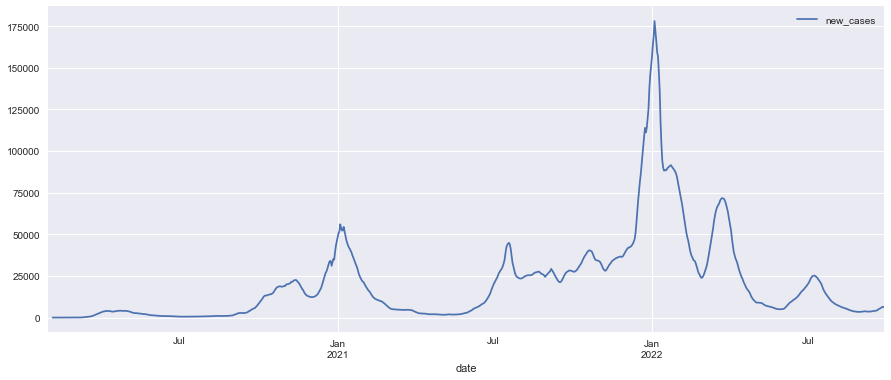

In [58]:
covid.rolling(window=7).mean().plot(figsize=(15,6));

Rolling averages smooth out spikes and changes in the data; with the bigger the window size, the more smoothing. So a fairly small window size like 3 (above) smooths out the most aggressive spikes, but leaves a lot of the fine detail intact. A larger window size like 7 (also above) smooths out more, but still leaves large-scale behaviour clear. A huge window size (below) will start to obscure even the overall structure. 

__Note:__ You should never use an overly large window size.

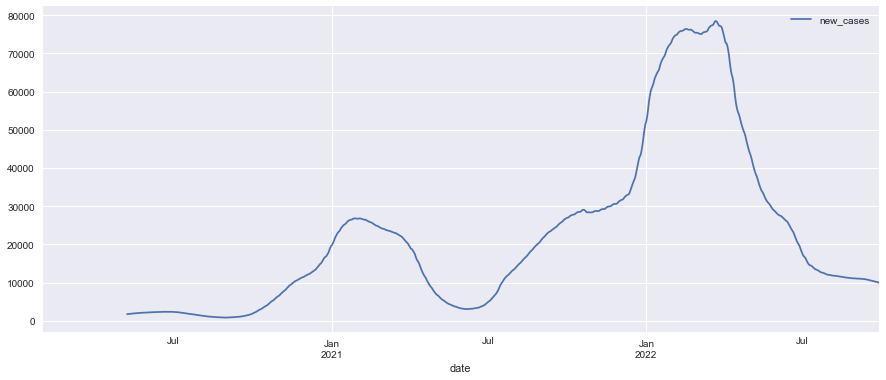

In [59]:
# never use a window size this big in practice!
covid.rolling(window=100).mean().plot(figsize=(15,6));

Rolling averages are good for looking at the overall <em>trend</em> of a time series, without getting distracted by the fine detail. When looking at trends, and other properties of time series, it can be useful to look at other rolling statistics:

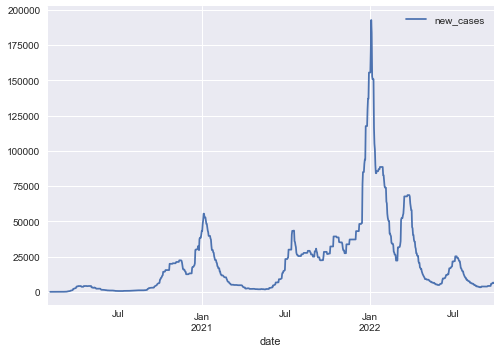

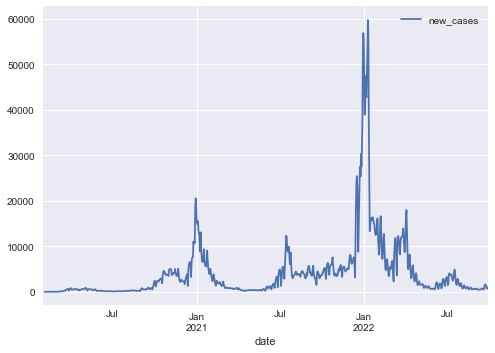

In [60]:
# can also calculate other rolling statistics, e.g., rolling median
covid.rolling(window=7).median().plot();
# rolling standard deviation - tend to use a larger window size for this.
covid.rolling(window=7).std().plot();

Comparing the rolling standard deviation to the actual data, we see that we get larger standard deviation (i.e., bigger short-term fluctuations in the data) when the value of the series is higher. This is <em>heteroskedasticity</em>, which literally means "different scatter" in Greek. 

A series is heteroskedastic if it has bigger fluctuations at some times than at others and is homoskedastic ("same scatter") if it has similar size fluctuations at all times.

A lot of time series models don't work well with heteroskedastic data, so the data need to be transformed to make them homoskedastic (e.g. taking the logarithm). There are also some models designed to work with heteroskedastic data, so those can be used instead.

---

Lets apply what we have learnt so far to another set of data, EU airline flights. Specifically we will be using the "Air passenger transport by reporting country (avia_paoc)" data on the [Eurostat website](https://ec.europa.eu/eurostat/web/transport/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_yjUOJMEUlFPI&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view) ([metadata](https://ec.europa.eu/eurostat/cache/metadata/en/avia_pa_esms.htm)).

__Note:__
If you turn `UPDATE = True`, it will save the latest airline data.

In [61]:
import requests
UPDATE = False

if UPDATE:
    url = "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/avia_paoc.tsv.gz"
    filename = "./Data/"+url.split("/")[-1]
    with open(filename, "wb") as f:
        r = requests.get(url)
        f.write(r.content)
    df = pd.read_csv(filename, compression='gzip', delimiter="\t|,", engine='python')
    # save to csv
    df.to_csv("./Data/passengerOverviewCountry_"+str(date.today())+".csv", index=False)
  
# get a list of the data files
onlyfiles = [f for f in os.listdir("Data") if os.path.isfile(os.path.join("Data", f))]
# only get the airlines data
passCountlist = list(filter(re.compile("passengerOverviewCountry_*").match, onlyfiles))
# load the latest data
pass_raw = pd.read_csv("./Data/"+passCountlist[-1])

# display the first few rows
pass_raw.head()

,unit,tra_meas,tra_cov,schedule,geo\time,2022Q2,2022Q1,2022M08,2022M07,2022M06,...,1993M09,1993M08,1993M07,1993M06,1993M05,1993M04,1993M03,1993M02,1993M01,1993
0,FLIGHT,CAF_PAS,INTL,N_SCHED,AT,1549,1453,:,952,747,...,:,:,:,:,:,:,:,:,:,18336
1,FLIGHT,CAF_PAS,INTL,N_SCHED,BE,:,3281,:,:,:,...,:,:,:,:,:,:,:,:,:,:
2,FLIGHT,CAF_PAS,INTL,N_SCHED,BG,2084,366,:,:,1395,...,:,:,:,:,:,:,:,:,:,:
3,FLIGHT,CAF_PAS,INTL,N_SCHED,CH,:,336,:,:,:,...,1969,2516,2619,1722,2013,1845,1344,1257,1648,21333
4,FLIGHT,CAF_PAS,INTL,N_SCHED,CY,2795,864,1336,1297,1163,...,:,:,:,:,:,:,:,:,:,:


As you can see we'll need to do a bit of tidying to get this data ready and looking like something below...

__Note__: This will also work with "Aircraft traffic data by reporting country (avia_tf_acc)" but this data has more missing data for the UK.

In [62]:
from helper_functions import tidy_eu_passengers

airlines = tidy_eu_passengers(pass_raw)
airlines.head()

,unit,measurement,coverage,schedule,country,vals
date,,,,,,
1993-01-01,PAS,PAS_CRD_DEP,TOTAL,UNK,Sweden,NaN
1993-01-01,FLIGHT,CAF_PAS_DEP,TOTAL,UNK,Portugal,NaN
1993-01-01,FLIGHT,CAF_PAS_DEP,TOTAL,UNK,Sweden,NaN
1993-01-01,PAS,PAS_BRD,INTL,N_SCHED,Austria,NaN
1993-01-01,PAS,PAS_BRD,INTL,N_SCHED,Belgium,NaN


---

### 🚩 Exercise 13 (Extra)

See if you can create the `tidy_eu_planes` function yourself. You'll need to:
- Rename columns
- Select only monthly data
- Change the date to a datetime and set as the index
- Replace the country codes with country names
- Change missing values to `NAN`
- Change values to a float
- Sort from the earliest date to the most recent

In [63]:
%run ../scripts/show_solutions.py 12_ex13

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

For our current data, we will just get the number of passengers from uk airports in all international and national flights.

In [64]:
uk_flights = airlines[(airlines["country"] == "UK") &          # UK
                      (airlines["unit"] == "PAS") &            # passengers
                      (airlines["measurement"] == "PAS_BRD") & # passengers on board
                      (airlines["schedule"] == "TOT") &
                      (airlines["coverage"] == "TOTAL")        # national and international
                     ]["vals"].copy() # just get the values

uk_flights.head()

date
1993-01-01   NaN
1993-02-01   NaN
1993-03-01   NaN
1993-04-01   NaN
1993-05-01   NaN
Name: vals, dtype: float64

---

### 🚩 Exercise 14

Plot the above data and discuss their trends. 

- Do you think we need to do any cleaning?
- Does smoothing out spikes in the data help give a more accurate estimate? 
- Is it a homoskedastic time series?

In [65]:
%run ../scripts/show_solutions.py 12_ex14

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
From now on, for the `uk_flights` data, we are going to focus on predicting the travel pre-covid so won't use data from 2020 onwards for now.

In [66]:
uk_flights = uk_flights.loc['2003-01-01':'2019-12-01']

---

### Shifting and Lagging

Another common operation on time series data to look at trends is to shift or lag values backward and forward in time. This can help us calculate the percentage of change from sample to sample (so we can calculate things such as  percentage daily change or other KPI's). 

Pandas has a `.shift()` method for shifting the data in a DataFrame.

In [67]:
covid.head(10)

,new_cases
date,
2020-01-30,1
2020-01-31,0
2020-02-01,0
2020-02-02,1
2020-02-03,18
2020-02-04,0
2020-02-05,1
2020-02-06,0
2020-02-07,0


In [68]:
covid_forward = covid.shift(1)
covid_forward.head(10)

,new_cases
date,
2020-01-30,NaN
2020-01-31,1.0
2020-02-01,0.0
2020-02-02,0.0
2020-02-03,1.0
2020-02-04,18.0
2020-02-05,0.0
2020-02-06,1.0
2020-02-07,0.0


Notice that the first row now contains NaN values because there wasn't a previous day's data to shift to that day. Also notice the values have been shifted and not the datetime. If you want to keep the dates correct after lagging you'll also need to move the index...

In [69]:
# indicate it is a daily frequency - you need a freqency to shift
covid_forward.index.freq = 'd'
# move the dates back
covid_forward.index = covid_forward.index.shift(-1)
covid_forward.head(10)

,new_cases
date,
2020-01-29,NaN
2020-01-30,1.0
2020-01-31,0.0
2020-02-01,0.0
2020-02-02,1.0
2020-02-03,18.0
2020-02-04,0.0
2020-02-05,1.0
2020-02-06,0.0


---

### 🚩 Exercise 15

Shift the covid cases by a week.
- Plot the lagged data vs the actual.

In [70]:
%run ../scripts/show_solutions.py 12_ex15

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
Lags can be used to calculate the changes in the values you are tracking with your time series data. In this case, we can use Pandas' `.shift()` method to look at the changes in covid cases based on the previous day. 

In [71]:
covid_change = covid.copy()

covid_change["change"] = covid - covid.shift(1)
covid_change.head(20)

,new_cases,change
date,,
2020-01-30,1,NaN
2020-01-31,0,-1.0
2020-02-01,0,0.0
2020-02-02,1,1.0
2020-02-03,18,17.0
2020-02-04,0,-18.0
2020-02-05,1,1.0
2020-02-06,0,-1.0
2020-02-07,0,0.0


---

### 🚩 Exercise 16

Shift the `uk_flights` data to get the monthly change.

__Note__
- You may need to use `fill_value=0`in the `.shift`.

In [72]:
%run ../scripts/show_solutions.py 12_ex16

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

We can also use lags to start to look into seasonality.

---

## 3.2. Seasonality

A time series is <em>seasonal</em> if it has a regular repeating pattern <strong>with a fixed, known frequency</strong>. The number of data points before the pattern repeats is called the <em>seasonal period</em>. Monthly data, for example, often has seasonality with period 12 (each year), hourly data often has period 24 (each day), etc.

A time series could also be <em>cyclic</em> or has <em>cycles</em> if it has repeating patterns <strong>at irregular intervals</strong>. So repeating behaviour is seasonal if it always happens at fixed intervals, and cyclic if it happens irregularly. Cyclic data is much harder to forecast accurately, because you don't know when the next cycle will occur; often the best you can do is say on average the level of the series. Seasonal data however can often be accurately forecast.

Lets look at our `uk_flights` data. We can make a good assumption that there is going to be a pattern that is similar across months (e.g. january in 2018 may be similar to january 2019). We can observe this by plotting the original data as well as a shifted version.

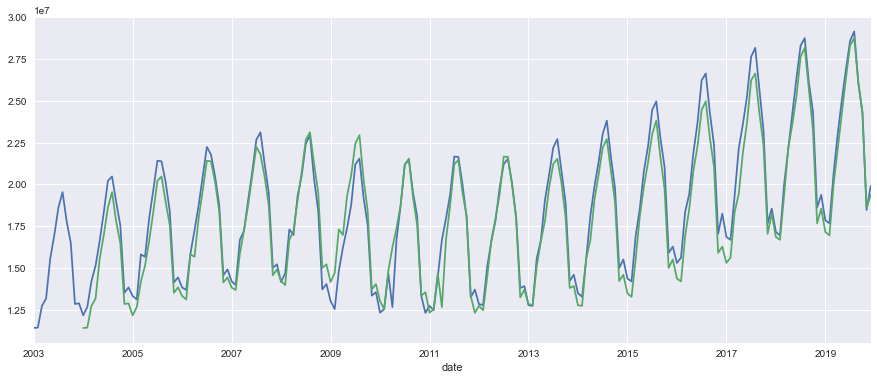

In [73]:
fig, ax = plt.subplots()
uk_flights.plot(ax=ax);
uk_flights.shift(12).plot(ax=ax, figsize=(15,6));

Indeed, if we quantify this relationship with a correlation (each point with its 12 month lagged version), we see a very high correlation.

In [74]:
from scipy.stats import pearsonr

# we need to shift the first 12 values as the function cannot take na's
corr, p = pearsonr(uk_flights.iloc[12:], uk_flights.shift(12).iloc[12:])

print("Correlation: " + str(round(corr,3)))
print("P-Value: " + str(round(p,3)))

Correlation: 0.977
P-Value: 0.0


As we can see, 0.98 is a very strong correlation and the p-value indicates that the probability of seeing a correlation this strong (or stronger) from random data is absolutely tiny, so there's no chance that this correlation is just down to luck. So the series is very strongly correlated with itself a month later. This shows seasonality.

__Note:__ 
If you don't round, you will see the p-value in scientific notation ("e-129"). The value 3.60e-129 means $3.6\times 10^{-129}$.

So currently we have observed that the data is highly correlated with itself at lag 12 (12 months difference) but we can extend this and see if the series is correlated with itself at multiple different lags using <em>autocorrelation</em>.

We normally the AutoCorrelation Function (ACF) to calculate the correlation of the series with itself at several different shifts and plots those correlation values. It also gives us an idea of significance, anything in the blue shaded area is not a significantly strong correlation.

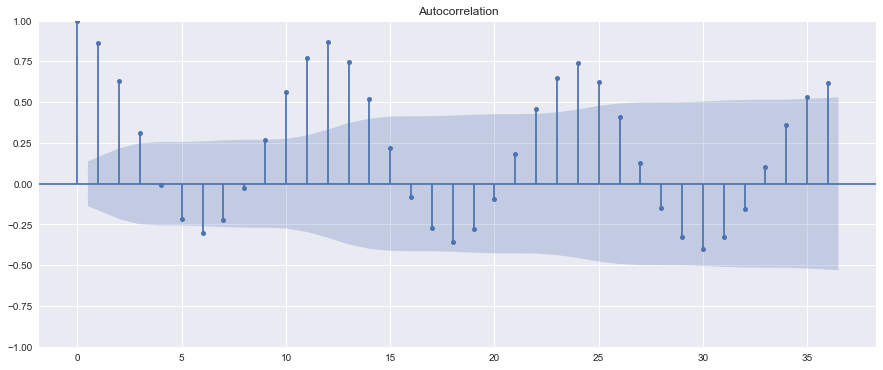

In [75]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(15,6))

plot_acf(uk_flights, lags=36, ax=ax);

We can see that the value in the last month is typically highly correlated with the current month (lag 1). This makes sense because with a time series the current value is often dependent on the previous value (there is unlike to all of a sudden be loads more or fewer flights in Feburary than January). This correlation then decreases as we get further away from the current month, then at lag 9 starts to get similar again as we get closer to the same month but a year apart (which again we would expect). So based on this we are likely dealing with an auto-regressive process (more on this later).

Above is a good example of seasonality in ACF plots as seasonality is visible by a repeating spike every multiple of $m$ (where $m$ is the seasonal period, e.g., $m=12$). Cyclic behaviour does not show up in the ACF plot, because when you shift irregular cycles, they don't line up, so you don't get a strong correlation.

A drawback of this approach we need to account for is that there can be a problem in using ACF on strongly trended data with weak seasonality as the trend can obscure the seasonality. For example if we look at the number of rail passengers in the UK we'll see exactly that.

__Note:__ Here we are using the "Passengers transported (detailed reporting only) - (quarterly data)" data on the [Eurostat website](https://ec.europa.eu/eurostat/web/transport/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_yjUOJMEUlFPI&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view). Its similar to the airline data but instead reported quarterly rather than monthly.

date
2004-01-01    264878.0
2004-04-01    260330.0
2004-07-01    265318.0
2004-10-01    279146.0
2005-01-01    267571.0
Name: vals, dtype: float64

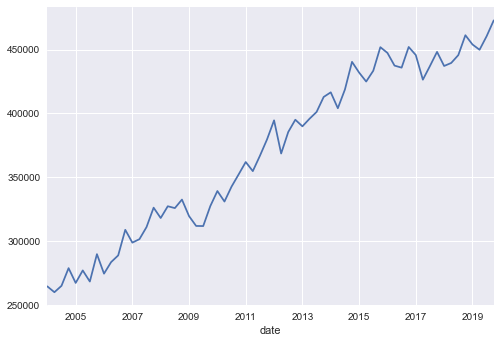

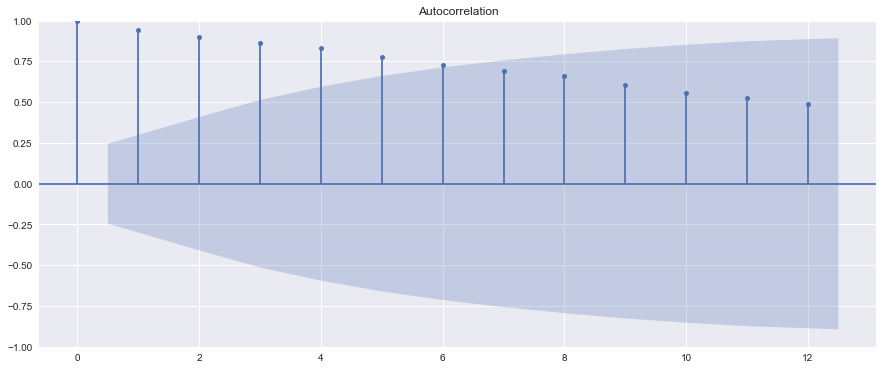

In [76]:
from helper_functions import tidy_eu_rail_passengers
UPDATE = False

if UPDATE:
    url = "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/rail_pa_quartal.tsv.gz"
    filename = "./Data/"+url.split("/")[-1]
    with open(filename, "wb") as f:
        r = requests.get(url)
        f.write(r.content)
    df = pd.read_csv(filename, compression='gzip', delimiter="\t|,", engine='python')
    # save to csv
    df.to_csv("./Data/railPassengerOverviewCountry_"+str(date.today())+".csv", index=False)
  
# get a list of the data files
onlyfiles = [f for f in os.listdir("Data") if os.path.isfile(os.path.join("Data", f))]
# only get the airlines data
railPassCountlist = list(filter(re.compile("railPassengerOverviewCountry_*").match, onlyfiles))
# load the latest data
railpass_raw = pd.read_csv("./Data/"+railPassCountlist[-1])
# tidy it up
railpass = tidy_eu_rail_passengers(railpass_raw)
# get UK data
uk_rail = railpass[(railpass["country"] == "UK") &          # UK
                   (railpass["unit"] == "THS_PAS")          # Thousand passengers
                  ]["vals"].copy()                          # just get the values
# don't include 2020
uk_rail = uk_rail.loc[:"2019-10-01"]

display(uk_rail.head())

uk_rail.plot()
plt.show()

fig, ax = plt.subplots(figsize=(15,6))

plot_acf(uk_rail, lags=12, ax=ax);

As we can see in the first plot, this data has a very clear trend upwards over time. Trend (either upwards or downwards) is visible in an ACF plot (second plot) by a gradual decrease in the values (as above). Above in the rail data we may expect to see a quaterly trend (lag 4), but cannot; indeed it may well be the strong trend is obsuring this seasonality. To observe whether the rail data has seasonality in the ACF plot we will first then have to remove the trend.

To capture trend, we can use integration/differencing. The idea is to look at the difference from one value of the time series to the next, rather than the raw values. This often removes trend - because if a time series is trending upwards at a steady rate, then the difference from one observation to the next is a consistent positive value - so roughly a constant, with no trend.

We can use `.diff` in pandas to achive this.

In [77]:
uk_rail_ = pd.DataFrame(uk_rail)

uk_rail_["difference"] = uk_rail.diff()
uk_rail_

,vals,difference
date,,
2004-01-01,264878.0,NaN
2004-04-01,260330.0,-4548.0
2004-07-01,265318.0,4988.0
2004-10-01,279146.0,13828.0
2005-01-01,267571.0,-11575.0
...,...,...
2018-10-01,461161.0,15546.0
2019-01-01,453939.0,-7222.0
2019-04-01,449794.0,-4145.0


Indeed if we plot the data you can see that comparatively the differenced data (at the bottom) does not trend upwards anymore.

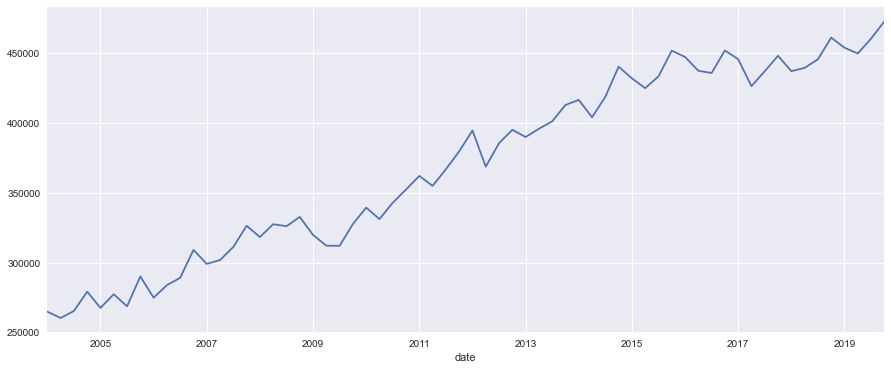

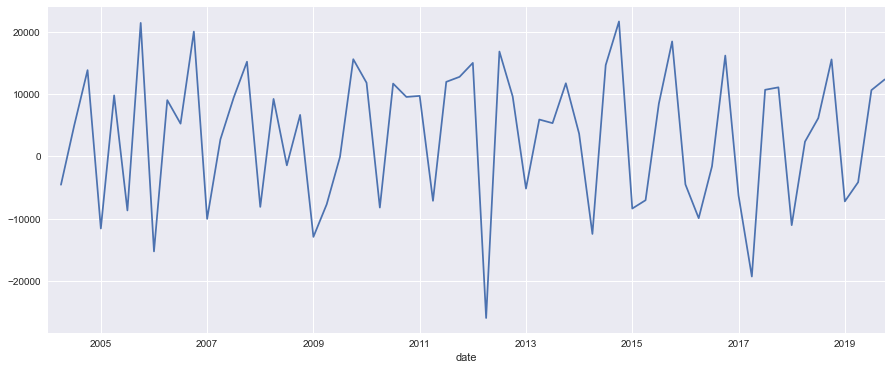

In [78]:
uk_rail.plot(figsize=(15,6))
plt.show()
# difference to remove trend
uk_rail.diff().plot(figsize=(15,6));

Indeed if we look at the ACF on the differenced rail data, you can more more clearly see the seasonal spike every quater as it is no longer obscured by the trend.

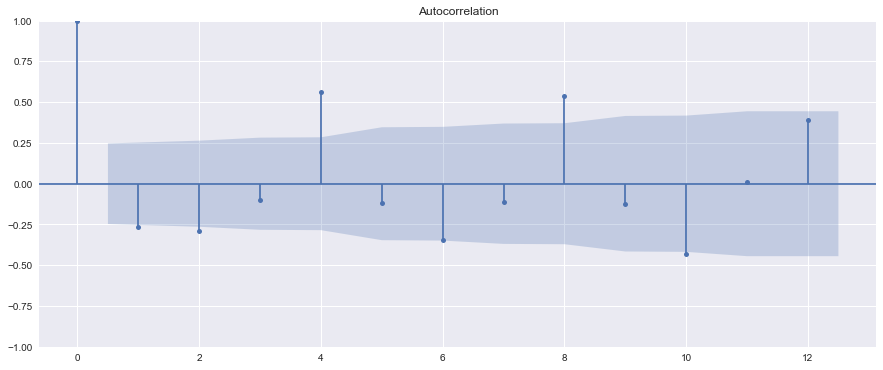

In [79]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(uk_rail.diff().dropna(), lags=12, ax=ax);

---

### 🚩 Exercise 17

Difference the `uk_flights` data and see how this changes your ACF plot.

In [80]:
%run ../scripts/show_solutions.py 12_ex17

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values, describing how well the present value is related with its past values. A time series have all sorts of components like trends, seasonality, cycles, and residual and each of these components will represent an underlying pattern. 

- **Trend**: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes, we will refer to a trend “changing direction” when, for example, it might go from an increasing trend to a decreasing trend.

- **Seasonal**: A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.

- **Residual**: The leftover or error component.

We can see these components in our rail data using `seasonal_decompose`.

__Note:__ We're using a frequency of 4 because the rail data is quaterly.

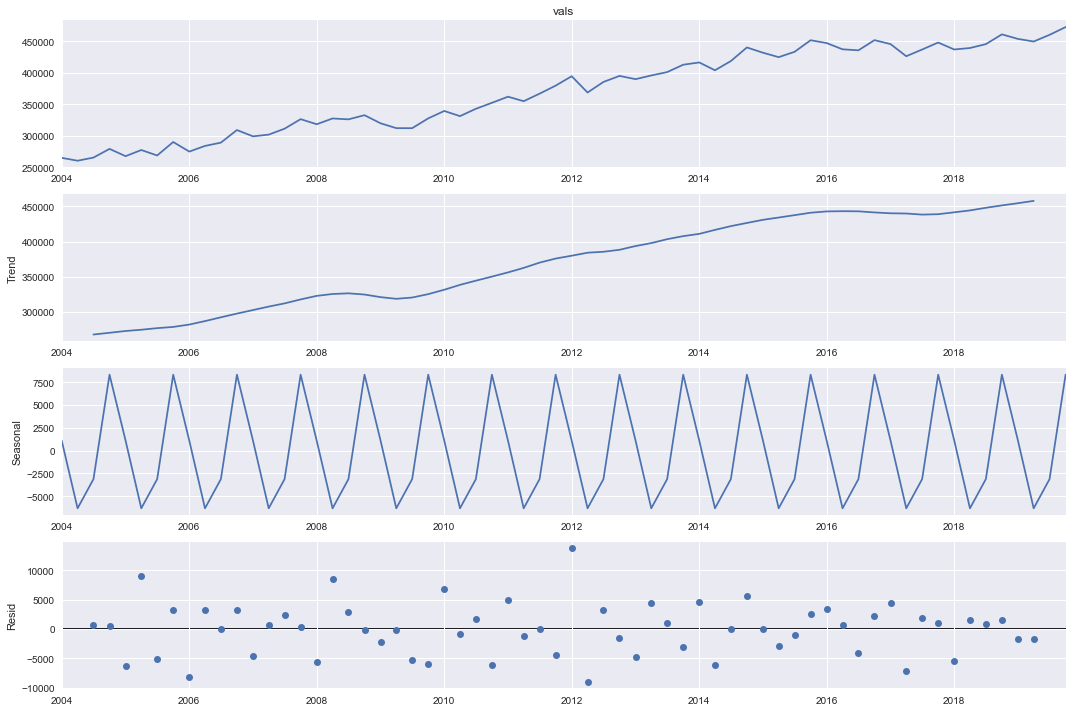

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose

rail_decomp = seasonal_decompose(uk_rail, period=4) # older versions of statsmodels have freq instead of period
fig = rail_decomp.plot()
fig.set_size_inches((15,10))
fig.tight_layout() # Tight layout to realign things
plt.show()

ACF considers all these components when calculating the correlation between a current value and a previous value - hence it’s a ‘complete auto-correlation plot’.

We could also use a __partial auto-correlation function (PACF)__. Instead of finding correlations of present with lags, we could find the correlation of the residuals (what remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’. We are removing already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling.

Like ACF, PCAF doesn't work as well when we have non-stationary data (a time series is "stationary" if it looks basically centered around some number). As both our data is non-stationary due to the trend, we need to difference first before doing the PCAF as well.

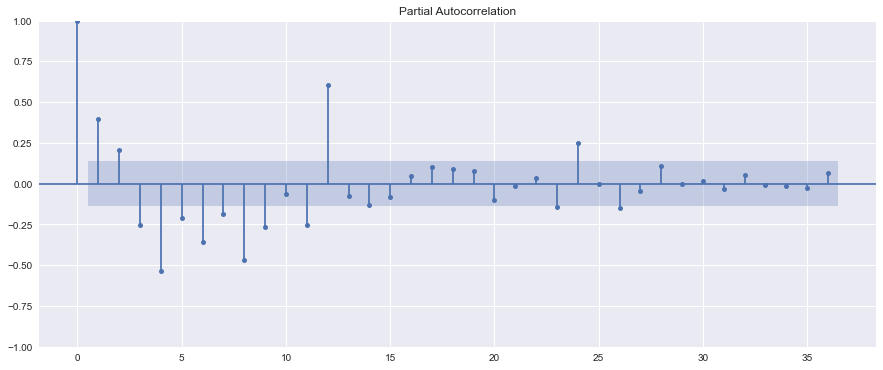

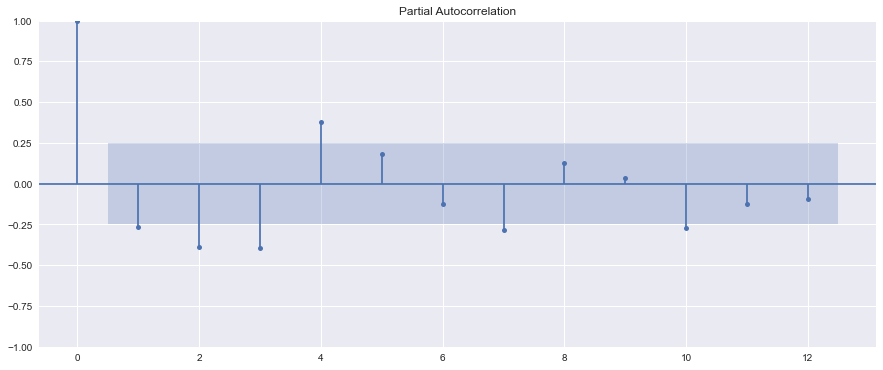

In [82]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(uk_flights.diff().dropna(), lags=36, ax=ax, method='ywm');
plt.show()

fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(uk_rail.diff().dropna(), lags=12, ax=ax, method='ywm');
plt.show()

This is further confirming that even when accounting for the information in previous lags, the flights data has a 12 month seasonality and the rail data a 4 quater seasonality.

---

### 🚩 Exercise 18

Resample the covid data to get the total cases per week and look at the autocorrelation over a year. 
- How many weeks ahead do you think are reliably correlated?
- Do you think there is any seasonality?
- Do you think the data is non-stationary?

In [83]:
%run ../scripts/show_solutions.py 12_ex18

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
Differencing can also make it easier to spot heteroskedasticity, which as we mentioned can be an issue for some time series models. The airline data is not heteroskedastic as it has bigger fluctuations in later months than earlier ones.

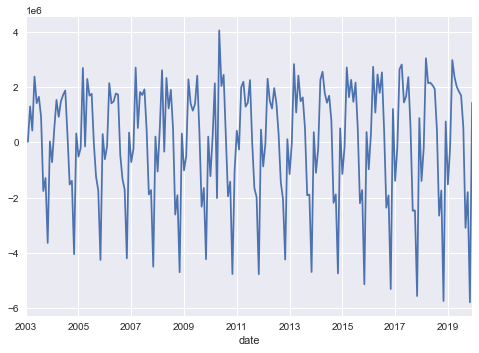

In [84]:
uk_flights.diff().plot();

There are ways to deal with heteroskedastic data such as taking the logarithm, so lets do that.

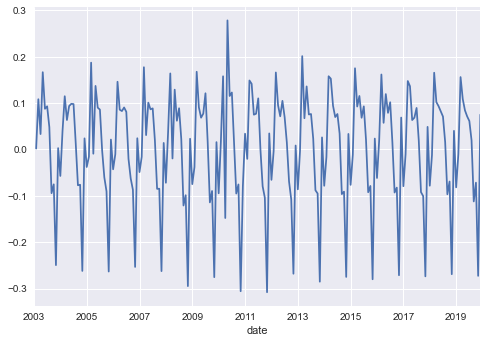

In [85]:
import numpy as np

uk_flights_ = pd.DataFrame(uk_flights).copy()

uk_flights_['log'] = np.log(uk_flights_)

uk_flights_['log'].diff().plot();
plt.show()

For heteroskedastic data, the default `seasonal_decompose` doesn't always work very well. You sometimes get a better decomposition with a multiplicative method (`model='multiplicative'`). A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model.

---

### 🚩 Exercise 19

Decompose the flight and covid data. Do you think these decompositions have worked well?

In [110]:
%run ../scripts/show_solutions.py 12_ex19

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 4. Model Exploration/Refinement <a id='explore'></a>

So far we have been doing _"time-series analysis"_ by extracting meaningful statistics and characteristics from the data. Now we are going to use that information to do _"time-series forecasting"_, where we predict future values based on previously observed values. Like other predictive models discussed in previous workbooks, future values are predicted using historical values, and we will evaluate the models on how they perform on seen and unseen data. However, unlike previous models, the predictions from earlier time points will also make up the inputs for prediction.

Another unqiue quality of timeseries compared to what we have seen before is that the data is time dependent. Models such as linear regression assume that the observations are independent - here we are assuming they also have trend or seasonality (meaning observations are dependent on their previous values). Because of this, we are assuming there is autocorrelation in our data unlike in regression modelling where we assume residuals/error terms are independent of one another.

__Note__
- [This video](https://www.youtube.com/watch?v=ZoJ2OctrFLA&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&ab_channel=ritvikmath) does a good job of explaining this.

## 4.1. Train-test split

As mentioned, we will split our data into training and testing subsets. This allows us to train our model and compare its prediction with the testing subset. If satistifed with the model performance, we can then retrain it with all the data and then forecast future values.

As time series data have a natural temporal ordering, we need to account for this in our splits. Because these data are ordered, we **cannot choose training and testing examples at random.** As we are attempting to predict _a sequence of future values_, we must train on values from earlier (in time) in our data and then test our values at the end of the period.

For our UK flights data, lets therefore use the data from 2003-2017 to predict the UK flights in 2018 and 2019.

In [87]:
test_start = pd.to_datetime('2018-01-01')

flights_train = uk_flights.loc[:test_start-pd.DateOffset(months=1)]
flights_test = uk_flights.loc[test_start:]

display(flights_train.tail())
display(flights_test.head())

date
2017-08-01    28170671.0
2017-09-01    25693433.0
2017-10-01    23232302.0
2017-11-01    17669601.0
2017-12-01    18548439.0
Name: vals, dtype: float64

date
2018-01-01    17153007.0
2018-02-01    16944281.0
2018-03-01    19990006.0
2018-04-01    22135672.0
2018-05-01    24297505.0
Name: vals, dtype: float64

Lets now visualise the train-test split.

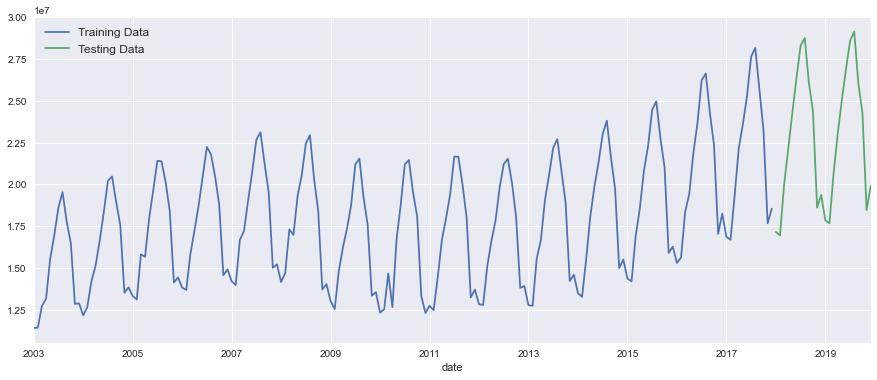

In [107]:
flights_train.plot(label="Training Data", figsize=(15,6))
flights_test.plot(label="Testing Data")

plt.legend(fontsize=12)
plt.show()

## 4.1. Naive Forcasting

If we think the number of flights have been stable from 2003, we could just take the last time period's number of airlines and estimate the same value for the next time period. Such a forecasting technique, which assumes that the next expected point is equal to the last observed point, is called a **naive method**.

In [89]:
# copy the test data
y_hat = flights_test.to_frame().copy()
# get the last training value and add this as a value for each
# test data
y_hat['naive'] = flights_train[len(flights_train)-1]

y_hat.head()

,vals,naive
date,,
2018-01-01,17153007.0,18548439.0
2018-02-01,16944281.0,18548439.0
2018-03-01,19990006.0,18548439.0
2018-04-01,22135672.0,18548439.0
2018-05-01,24297505.0,18548439.0


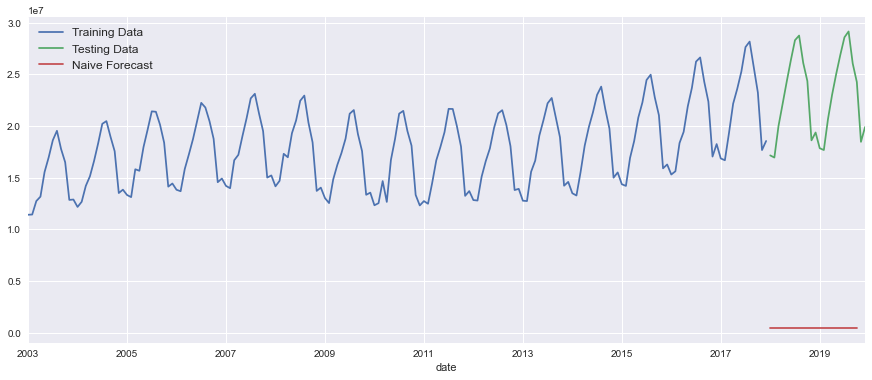

In [106]:
flights_train.plot(label="Training Data", figsize=(15,6))
flights_test.plot(label="Testing Data")
y_hat['naive'].plot(label='Naive Forecast')

plt.legend(fontsize=12)
plt.show()

Let's use RMSE to check the accuracy of our model on the test data set. Outliers are 'punished' by the squaring done in the MSE while square-rooting the result will output a value that is in the same unit as the data (in our case, number of flights).

As a refresher, MSE takes the average of the squared distances between predicted points and the actual data.

In [92]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(flights_test, y_hat['naive']))  # using np.exp() to cancel the log transformation
print('RMSE:', round(rmse,2))

RMSE: 5936911.66


So on average this model is wrong by nearly six million passengers... so not a great model, although we probably could have expected that as the naive method isn’t suited for data sets with high variability!

However if for some reason you wanted to use this to predict the future, you could do something like below...

In [93]:
# number of future predictions we want to make
num_preds = 12

# start a list with the first date you want to predict
# then increment by each month
prediction_times = [pd.to_datetime('2020-01-01')]
for i in range(num_preds-1):
    prediction_times.append(prediction_times[-1]+ pd.DateOffset(months=1))
    
# make a list of the value increasing the number of predictions you want to make
naive_pred=[flights_train[len(flights_train)-1]]*num_preds

# turn to dataframe with the time as the index
future_pred = pd.DataFrame(naive_pred, index = prediction_times)
future_pred

,0
2020-01-01,18548439.0
2020-02-01,18548439.0
2020-03-01,18548439.0
2020-04-01,18548439.0
2020-05-01,18548439.0
2020-06-01,18548439.0
2020-07-01,18548439.0
2020-08-01,18548439.0
2020-09-01,18548439.0
2020-10-01,18548439.0


## 4.2. Simple Average
Another simple model that assumes little variability (the values of interest are increasing and decreasing randomly by a small margin) and the average remains constant is to compute a _Simple Average_. Simple average forecasts the number of flights of the next time period to be somewhat similar to the average of all of the previous time periods. 

In [95]:
# get the average of the training data
y_hat['avg_forecast'] = flights_train.mean()

y_hat.head()

,vals,naive,avg_forecast
date,,,
2018-01-01,17153007.0,18548439.0,1.777885e+07
2018-02-01,16944281.0,18548439.0,1.777885e+07
2018-03-01,19990006.0,18548439.0,1.777885e+07
2018-04-01,22135672.0,18548439.0,1.777885e+07
2018-05-01,24297505.0,18548439.0,1.777885e+07


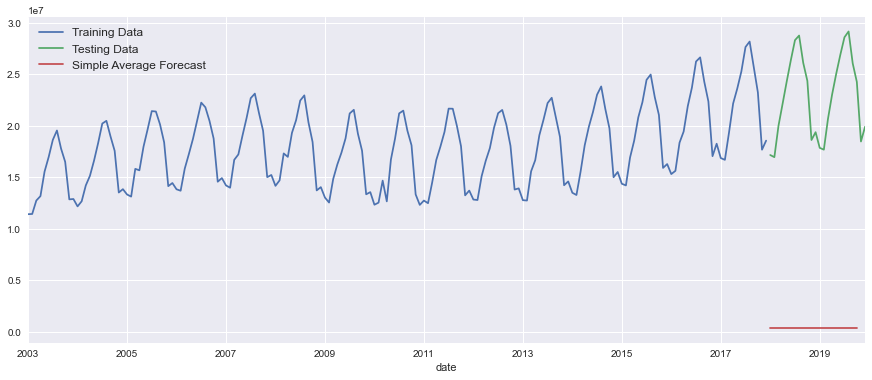

In [105]:
flights_train.plot(label="Training Data", figsize=(15,6))
flights_test.plot(label="Testing Data")
y_hat['avg_forecast'].plot(label='Simple Average Forecast')

plt.legend(fontsize=12)
plt.show()

Now, let's calculate RMSE to check to accuracy of our model.

In [99]:
rmse = np.sqrt(mean_squared_error(flights_test, y_hat['avg_forecast']))
print('RMSE:', round(rmse,2))

RMSE: 6523685.39


This model is even worse! Like the Naive method, the simple average method works best when the average at each time period remains constant but with our increasing trend this does not work very well! We're going to need to use some more advanced methods.

---

### 🚩 Exercise 20

On the `uk_rail` data, get the RMSE of a naive and average model. How well do these perform?

__Note__
- You may as well use the same splits (i.e. checking how the model does on 2018 & 2019 data).

In [112]:
%run ../scripts/show_solutions.py 12_ex20

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Extra Exercise

Using the "Air passenger transport by main airports in each reporting country (avia_paoa)" data on the [Eurostat website](https://ec.europa.eu/eurostat/web/transport/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_yjUOJMEUlFPI&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view), try forcast the passenger numbers for your closest (or desired) airport.

**Note**
- This data is larger!

In [ ]:
%run ../scripts/show_solutions.py 12_ex99

__IDEAS__
- there are also frieght and mail stuff. Wonder if that has seasonality? Maybe would make a good question?